# SEQUENCE CLASSIFICATION

In [1]:
from __future__ import print_function
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader

LOAD DATASET

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

root = './data'
train_data = datasets.MNIST(root, train=True, download=True, transform=transform)
valid_data = datasets.MNIST(root, train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,
                          num_workers=4, drop_last=False)
valid_loader = DataLoader(valid_data, batch_size=100, shuffle=False,
                          num_workers=4)

/home/jongwooko/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Visualization of MNIST dataset

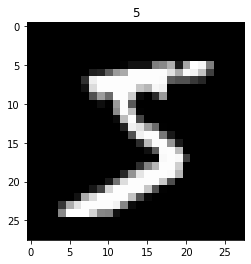

In [3]:
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

Plot multiple train data

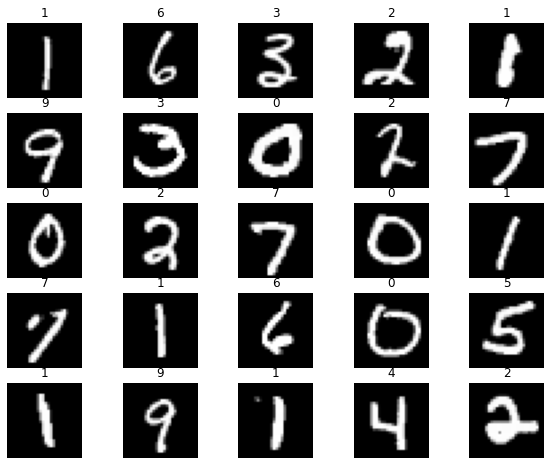

In [4]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# DEFINE MODEL

In [5]:
class MNISTRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classses, use_cuda=False):
        super(MNISTRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = torch.device('cuda') if use_cuda else torch.device('cpu')
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
        
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Passing in the input and hidden state into the model and  obtaining outputs
        out, hidden = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        #Reshaping the outputs such that it can be fit into the fully connected layer
        out = self.fc(out[:, -1, :])
        return out

# DEFINE PARAMETERS

In [6]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = MNISTRNN(input_size, hidden_size, num_layers, num_classes, torch.cuda.is_available()).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train

In [7]:
model.train()
for epoch in range(num_epochs):
    avg_loss = 0.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        avg_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_loss /= len(train_loader)
    print('Epoch:', '%04d' % (epoch), 'Loss =', '{:.6f}'.format(avg_loss))
        
print ('OPTIMIZATION FINISHED')

Epoch: 0000 Loss = 0.352675
Epoch: 0001 Loss = 0.148410
OPTIMIZATION FINISHED


# Test

In [8]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for inputs, targets in valid_loader:
        inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        total = total + targets.size(0)
        correct = correct + (preds == targets).sum().item()
        
print ('Test Accuracy of the model on the 10000 valid images {}%'.format(100 * correct / total))

Test Accuracy of the model on the 10000 valid images 95.09%
